# Question and Answer (QA) Chat Bots

----

------

## Chargement des données

Nous allons travailler avec le dataset Babi de Facebook Research.

Détails complets: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698


In [7]:
import pickle
import numpy as np

In [8]:
with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

In [9]:
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

----

## Explorer le format des données

In [4]:
type(test_data)

list

In [5]:
type(train_data)

list

In [6]:
len(test_data)

1000

In [7]:
len(train_data)

10000

In [8]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [9]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [11]:
train_data[0][2]

'no'

-----

## Mise en place d'un vocabulaire de tous les mots

In [12]:
# Create a set that holds the vocab words
vocab = set()

In [13]:
all_data = test_data + train_data

In [14]:
for story, question , answer in all_data:
    # In case you don't know what a union of sets is:
    # https://www.programiz.com/python-programming/methods/set/union
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [15]:
vocab.add('no')
vocab.add('yes')

In [16]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [17]:
vocab_len = len(vocab) + 1 #we add an extra space to hold a 0 for Keras's pad_sequences

In [18]:
max_story_len = max([len(data[0]) for data in all_data])

In [19]:
max_story_len

156

In [20]:
max_question_len = max([len(data[1]) for data in all_data])

In [21]:
max_question_len

6

## Vectorisation des données

In [22]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [23]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

-----------

In [24]:
#from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [25]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [26]:
tokenizer.word_index

{'went': 1,
 'travelled': 2,
 'discarded': 3,
 'to': 4,
 'yes': 5,
 'got': 6,
 'up': 7,
 '?': 8,
 'picked': 9,
 'apple': 10,
 'in': 11,
 'no': 12,
 'moved': 13,
 '.': 14,
 'sandra': 15,
 'back': 16,
 'the': 17,
 'bedroom': 18,
 'is': 19,
 'took': 20,
 'dropped': 21,
 'down': 22,
 'garden': 23,
 'mary': 24,
 'there': 25,
 'daniel': 26,
 'journeyed': 27,
 'football': 28,
 'milk': 29,
 'put': 30,
 'john': 31,
 'bathroom': 32,
 'grabbed': 33,
 'kitchen': 34,
 'left': 35,
 'hallway': 36,
 'office': 37}

In [27]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [28]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [29]:
len(train_story_text)

10000

In [30]:
len(train_story_seq)

10000

In [31]:
# word_index = tokenizer.word_index

### Functionalize Vectorization

In [32]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [33]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [34]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [35]:
inputs_test

array([[ 0,  0,  0, ..., 17, 18, 14],
       [ 0,  0,  0, ..., 17, 23, 14],
       [ 0,  0,  0, ..., 17, 23, 14],
       ...,
       [ 0,  0,  0, ..., 17, 10, 14],
       [ 0,  0,  0, ..., 17, 23, 14],
       [ 0,  0,  0, ..., 10, 25, 14]])

In [36]:
queries_test

array([[19, 31, 11, 17, 34,  8],
       [19, 31, 11, 17, 34,  8],
       [19, 31, 11, 17, 23,  8],
       ...,
       [19, 24, 11, 17, 18,  8],
       [19, 15, 11, 17, 23,  8],
       [19, 24, 11, 17, 23,  8]])

In [37]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,
         0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [39]:
tokenizer.word_index['yes']

5

In [40]:
tokenizer.word_index['no']

12

## Création du modèle

In [44]:
from keras.models import Sequential, Model
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

### Placeholders pour les Inputs

Rappelons que nous avons techniquement deux entrées, les histoires et les questions. Nous avons donc besoin d'utiliser des placeholders. `Input()` est utilisé pour instancier un tenseur Keras.


In [45]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Building the Networks

Pour comprendre pourquoi nous avons choisi cette configuration, lisez le document que nous utilisons :

* Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Input Encoder m

In [46]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder c

In [47]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [48]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [49]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

##### Utiliser le produit (dot) pour calculer la correspondance entre le premier vecteur d'entrée seq et la requête.

In [50]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

#### Ajouter cette matrice de correspondance à la deuxième séquence de vecteurs d'entrée

In [51]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

#### Concatener

In [52]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [53]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [54]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [55]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [56]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_3[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_4[0][0]']                
                                                                                              

In [58]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 6s 14ms/step - loss: 0.9374 - accuracy: 0.4878 - val_loss: 0.7008 - val_accuracy: 0.5030
Epoch 2/120
313/313 [==============================] - 4s 13ms/step - loss: 0.7099 - accuracy: 0.4988 - val_loss: 0.6949 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 4s 14ms/step - loss: 0.6979 - accuracy: 0.5000 - val_loss: 0.6959 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6967 - accuracy: 0.4976 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6951 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 5s 16ms/step - loss: 0.6950 - accuracy: 0.5098 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6951 - accuracy: 0.5028 - val_loss: 0.6939 - val_accuracy:

313/313 [==============================] - 5s 15ms/step - loss: 0.3242 - accuracy: 0.8568 - val_loss: 0.4461 - val_accuracy: 0.8050
Epoch 114/120
313/313 [==============================] - 4s 14ms/step - loss: 0.3285 - accuracy: 0.8572 - val_loss: 0.4305 - val_accuracy: 0.8160
Epoch 115/120
313/313 [==============================] - 5s 14ms/step - loss: 0.3251 - accuracy: 0.8594 - val_loss: 0.4273 - val_accuracy: 0.8100
Epoch 116/120
313/313 [==============================] - 5s 16ms/step - loss: 0.3184 - accuracy: 0.8625 - val_loss: 0.4181 - val_accuracy: 0.8080
Epoch 117/120
313/313 [==============================] - 4s 14ms/step - loss: 0.3288 - accuracy: 0.8580 - val_loss: 0.4112 - val_accuracy: 0.8050
Epoch 118/120
313/313 [==============================] - 4s 14ms/step - loss: 0.3204 - accuracy: 0.8628 - val_loss: 0.4213 - val_accuracy: 0.8130
Epoch 119/120
313/313 [==============================] - 5s 15ms/step - loss: 0.3153 - accuracy: 0.8642 - val_loss: 0.4190 - val_accuracy:

### Sauvegarder le Modèle

In [70]:
filename = 'chatbot_120_epochs.h5'
#model.save(filename)

## Evaluer le Modèle

### Tracer l'historique de l'entrainement

In [67]:
history.history['accuracy']

[0.4878000020980835,
 0.49880000948905945,
 0.5,
 0.4975999891757965,
 0.5051000118255615,
 0.5098000168800354,
 0.5027999877929688,
 0.5040000081062317,
 0.4991999864578247,
 0.5008999705314636,
 0.4977000057697296,
 0.5040000081062317,
 0.5023000240325928,
 0.49639999866485596,
 0.5049999952316284,
 0.5044000148773193,
 0.5005000233650208,
 0.5,
 0.5034000277519226,
 0.4991999864578247,
 0.49950000643730164,
 0.4936999976634979,
 0.4918000102043152,
 0.5016000270843506,
 0.4966999888420105,
 0.49880000948905945,
 0.5055999755859375,
 0.5001000165939331,
 0.5045999884605408,
 0.49729999899864197,
 0.5153999924659729,
 0.5041000247001648,
 0.5020999908447266,
 0.5077000260353088,
 0.5001000165939331,
 0.5084999799728394,
 0.5120999813079834,
 0.516700029373169,
 0.5105000138282776,
 0.510200023651123,
 0.5192000269889832,
 0.5177000164985657,
 0.5228000283241272,
 0.5257999897003174,
 0.5253999829292297,
 0.5335999727249146,
 0.5482000112533569,
 0.5688999891281128,
 0.5838000178337097

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


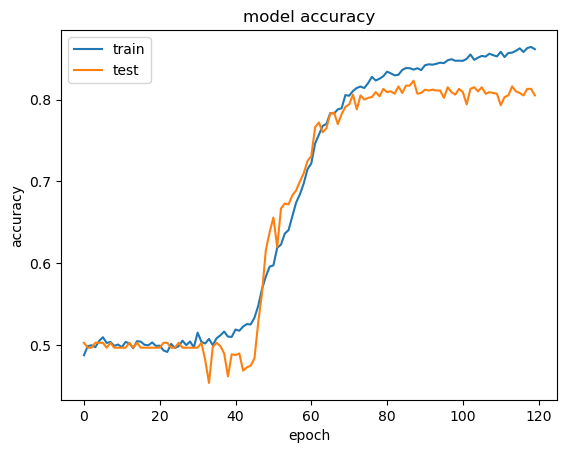

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluer sur un test set donné

In [71]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 2ms/step


In [73]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [74]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [75]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [76]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [78]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999999


## Rédiger vos propres histoires et questions

N'oubliez pas que vous ne pouvez utiliser que des mots du vocabulaire existant.

In [59]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [80]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [81]:
my_question = "Is the football in the garden ?"

In [82]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [83]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [84]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [85]:
pred_results = model.predict(([ my_story, my_ques]))

In [86]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.97079676
